## Gender Distinguished Analysis and Parameter Tuning - by Yating Jing

- Build models for female patients and male patients separately.
- Fix earlier pipeline mistake (dimensionality reduction prior to classification).

In previous analysis, I made a mistakes with the dimensionality reduction - classification pipeline. Specifically, I reduced the dimension using PCA/LLE on the entire data before the training and testing procedure. This part is fixed in this notebook. 

Additionally, I tried SVM with RBF kernel and tuned some parameters.

In [1]:
import pandas as pd
import numpy as np

df_adhd = pd.read_csv('ADHD_Gender_rCBF.csv')
df_bipolar = pd.read_csv('Bipolar_Gender_rCBF.csv')

n1, n2 = df_adhd.shape[0], df_bipolar.shape[0]

print 'Number of ADHD patients (without Bipolar) is', n1
print 'Number of Bipolar patients (without ADHD) is', n2
print 'Chance before gender separation is', float(n1) / (n1 + n2)

Number of ADHD patients (without Bipolar) is 1484
Number of Bipolar patients (without ADHD) is 471
Chance before gender separation is 0.759079283887


In [2]:
# Separate the genders
adhd1_id, adhd2_id = list(), list()
bipolar1_id, bipolar2_id = list(), list()

for i, g in df_adhd[['Patient_ID', 'Gender_id']].values:
    if g == 1:
        adhd1_id.append(i)
    elif g == 2:
        adhd2_id.append(i)
        
for i, g in df_bipolar[['Patient_ID', 'Gender_id']].values:
    if g == 1:
        bipolar1_id.append(i)
    elif g == 2:
        bipolar2_id.append(i)
        
print 'Number of Gender 1 ADHD patients (without Bipolar) is', len(adhd1_id)
print 'Number of Gender 2 ADHD patients (without Bipolar) is', len(adhd2_id)
print 'Number of Gender 1 Bipolar patients (without ADHD) is', len(bipolar1_id)
print 'Number of Gender 2 Bipolar patients (without ADHD) is', len(bipolar2_id)

Number of Gender 1 ADHD patients (without Bipolar) is 1017
Number of Gender 2 ADHD patients (without Bipolar) is 467
Number of Gender 1 Bipolar patients (without ADHD) is 242
Number of Gender 2 Bipolar patients (without ADHD) is 228


In [3]:
# Separate ADHD data gender-wise
df_adhd1 = df_adhd.loc[df_adhd['Patient_ID'].isin(adhd1_id)].drop(['Patient_ID', 'Gender_id'], axis=1)
df_adhd2 = df_adhd.loc[df_adhd['Patient_ID'].isin(adhd2_id)].drop(['Patient_ID', 'Gender_id'], axis=1)
# Separate Bipolar data gender-wise
df_bipolar1 = df_bipolar.loc[df_bipolar['Patient_ID'].isin(bipolar1_id)].drop(['Patient_ID', 'Gender_id'], axis=1)
df_bipolar2 = df_bipolar.loc[df_bipolar['Patient_ID'].isin(bipolar2_id)].drop(['Patient_ID', 'Gender_id'], axis=1)

# Create disorder labels for classification
# ADHD: 0, Bipolar: 1
n1_adhd, n1_bipolar = len(adhd1_id), len(bipolar1_id)
n2_adhd, n2_bipolar = len(adhd2_id), len(bipolar2_id)
# Labels for gender 1
y1 = [0] * n1_adhd + [1] * n1_bipolar  
# Labels for gender 2
y2 = [0] * n2_adhd + [1] * n2_bipolar 

print 'Shape check:'
print 'ADHD:', df_adhd1.shape, df_adhd2.shape
print 'Bipolar:', df_bipolar1.shape, df_bipolar2.shape

# Gender1 data
df1_all = pd.concat([df_adhd1, df_bipolar1], axis=0)
# Gender2 data
df2_all = pd.concat([df_adhd2, df_bipolar2], axis=0)

print '\nDouble shape check:'
print 'Gender 1:', df1_all.shape, len(y1)
print 'Gender 2:', df2_all.shape, len(y2)

# Compute chances 
chance1 = float(n1_adhd)/(n1_adhd + n1_bipolar)
chance2 = float(n2_adhd)/(n2_adhd + n2_bipolar)
print 'Chance for gender 1 is', chance1
print 'Chance for gender 2 is', chance2

Shape check:
ADHD: (1017, 256) (467, 256)
Bipolar: (242, 256) (228, 256)

Double shape check:
Gender 1: (1259, 256) 1259
Gender 2: (695, 256) 695
Chance for gender 1 is 0.80778395552
Chance for gender 2 is 0.671942446043


## Machine Learning Utilities

### Principal Component Analysis

In [4]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Plot explained variance ratio
def plot_evr(ex_var_ratio):
    fig = plt.figure()
    plt.title('Explained Variance Ratios by PCA')
    plt.plot(ex_var_ratio)
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component')

def pca_fit(X, n=10):
    # PCA 
    pca = PCA(n_components=n)
    
    # Scale
    X_scaled = preprocessing.scale(X)
    
    # Fit 
    pc = pca.fit_transform(X_scaled)
    
    # print '\nExplained Variance Ratios:'
    # print pca.explained_variance_ratio_
    
    # print 'Sum of Explained Variance Ratios of the first', n, 'components is', 
    # print np.sum(pca.explained_variance_ratio_)

    # plot_evr(pca.explained_variance_ratio_)

    return pca, pc

def pca_transform(pca, X, n=10):
    X_scaled = preprocessing.scale(X)
    pc = pca.transform(X_scaled)
    return pc

### Locally Linear Embedding

In [5]:
from sklearn import preprocessing
from sklearn.manifold import LocallyLinearEmbedding

# Compute explained variance ratio of transformed data
def compute_explained_variance_ratio(transformed_data):
    explained_variance = np.var(transformed_data, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    explained_variance_ratio = np.sort(explained_variance_ratio)[::-1]
    return explained_variance_ratio

def lle_fit(X, n=10):
    # LLE
    lle = LocallyLinearEmbedding(n_neighbors=25, n_components=n, method='ltsa')
    # Scale
    X_scaled = preprocessing.scale(X)
    
    pc = lle.fit_transform(X_scaled)
    ex_var_ratio = compute_explained_variance_ratio(pc)    
    
    # print 'Explained Variance Ratios:'
    # print ex_var_ratio
    
    return lle, pc

def lle_transform(lle, X, n=10):
    X_scaled = preprocessing.scale(X)
    pc = lle.transform(X_scaled)
    return pc

### Classification

In [6]:
from sklearn.cross_validation import KFold

def train_test_clf(clf, clf_name, X, y, dr_method, k=10, n_comps=10):
    '''
    Train and test a classifier using K-fold cross validation
    Args:
        clf: sklearn classifier
        clf_name: classifier name (for printing)
        X: training data (2D numpy matrix)
        y: labels (1D vector)
        dr_method: dimensionality reduction method used to construct the features
        k: number of folds (default=10)
        n_comps: number of principal components to keep (default=10)
    '''
    X, y = np.array(X), np.array(y)
    kf = KFold(len(X), n_folds=k)
    scores = list()
    
    for i, (train_index, test_index) in enumerate(kf):
        # print 'Fold', i, '(10-fold CV)'
        # Train test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        X_train_redu, X_test_redu = [], []
        
        # Dimensionality Reduction
        if dr_method == 'PCA':
            # PCA fit
            pca, X_train_redu = pca_fit(X_train, n_comps)
            # PCA transform
            X_test_redu = pca_transform(pca, X_test, n_comps)
        elif dr_method == 'LLE':
            # LLE fit
            lle, X_train_redu = lle_fit(X_train, n_comps)
            # LLE transform
            X_test_redu = lle_transform(lle, X_test, n_comps)
            
        # Classification
        clf.fit(X_train_redu, y_train)
        score = clf.score(X_test_redu, y_test)
        scores.append(score)
        
    scores = np.array(scores)
    acc, acc_std = scores.mean(), scores.std()
    
    print clf_name + ' accuracy is %0.4f (+/- %0.3f)' % (acc, acc_std)
    return acc, acc_std

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

def classify(X, y, gender, dr_method, n_feats):
    '''
    Train and test a classifier 
    Args:
        X: training data (2D numpy matrix)
        y: labels (1D vector)
        gender: current gender genre (for plotting)
        dr_method: dimensionality reduction method used to construct the features
        n_feats: number of features used in classification
    '''
    lg = LogisticRegression(penalty='l2')
    lsvc = LinearSVC()
    svc = SVC(kernel='rbf')
    qda = QDA()
    rf = RandomForestClassifier(n_estimators=10, max_depth=5) 
    gb = GradientBoostingClassifier(n_estimators=20, max_depth=6)
    et = ExtraTreesClassifier(n_estimators=20, max_depth=6)
    ada = AdaBoostClassifier()

    classifiers = [lg, lsvc, svc, qda, rf, gb, et, ada]
    clf_names = ['Logistic Regression', 'Linear SVM', 'SVM (RBF)', 'QDA', \
                 'Random Forest', 'Gradient Boosting', 'Extra Trees', 'AdaBoost']
    accuracies = list()
    
    for clf, name in zip(classifiers, clf_names):
        # print '\n*********************************************************'
        acc, acc_std = train_test_clf(clf, name, X, y, dr_method, 10, n_feats)
        accuracies.append(acc)
        
    # Visualize classifier performance
    x = range(len(accuracies))
    width = 0.6/1.5
    plt.bar(x, accuracies, width)
    
    # Compute chance
    n0, n1 = y.count(0), y.count(1)
    chance = max(n0, n1) / float(n0 + n1)
    
    fig_title = gender + ' Classifier Performance on ' + dr_method + ' features'
    plt.title(fig_title, y=1.08)
    plt.xticks(x, clf_names, rotation=50)
    plt.xlabel('Classifier')
    plt.gca().xaxis.set_label_coords(1.1, -0.025)
    plt.ylabel('Accuracy')
    plt.axhline(chance, color='red', linestyle='--', label='chance') # plot chance
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.85))

## Gender 1 ADHD v.s. Bipolar Analysis

Using PCA features:

Logistic Regression accuracy is 0.8071 (+/- 0.386)
Linear SVM accuracy is 0.8071 (+/- 0.386)
SVM (RBF) accuracy is 0.8071 (+/- 0.386)
QDA accuracy is 0.7889 (+/- 0.371)
Random Forest accuracy is 0.8056 (+/- 0.385)
Gradient Boosting accuracy is 0.7921 (+/- 0.377)
Extra Trees accuracy is 0.8071 (+/- 0.386)
AdaBoost accuracy is 0.7730 (+/- 0.369)


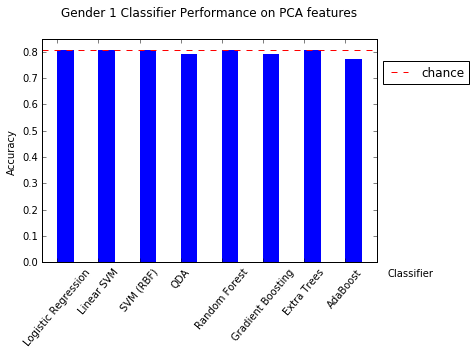

In [8]:
# Classification using PCA features
print 'Using PCA features:\n'
X1 = df1_all.values
classify(X1, y1, 'Gender 1', 'PCA', 10)

Using LLE features:

Logistic Regression accuracy is 0.8071 (+/- 0.386)
Linear SVM accuracy is 0.8063 (+/- 0.386)
SVM (RBF) accuracy is 0.8071 (+/- 0.386)
QDA accuracy is 0.9865 (+/- 0.022)
Random Forest accuracy is 0.8056 (+/- 0.385)
Gradient Boosting accuracy is 0.8048 (+/- 0.383)
Extra Trees accuracy is 0.8063 (+/- 0.386)
AdaBoost accuracy is 0.8040 (+/- 0.381)


/Library/Python/2.7/site-packages/sklearn/qda.py:124: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


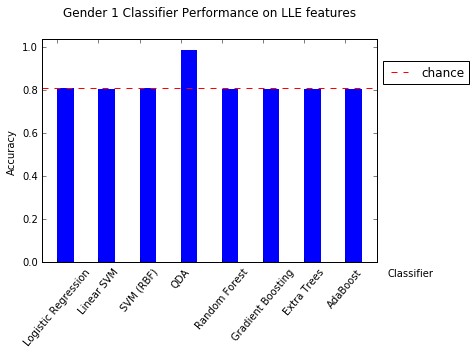

In [9]:
# Classification using LLE features
print 'Using LLE features:\n'
X1 = df1_all.values
classify(X1, y1, 'Gender 1', 'LLE', 15)

## Gender 2 ADHD v.s. Bipolar Analysis

Using PCA features:

Logistic Regression accuracy is 0.6553 (+/- 0.437)
Linear SVM accuracy is 0.6424 (+/- 0.425)
SVM (RBF) accuracy is 0.6639 (+/- 0.442)
QDA accuracy is 0.6096 (+/- 0.354)
Random Forest accuracy is 0.6324 (+/- 0.405)
Gradient Boosting accuracy is 0.5937 (+/- 0.365)
Extra Trees accuracy is 0.6667 (+/- 0.445)
AdaBoost accuracy is 0.5480 (+/- 0.307)


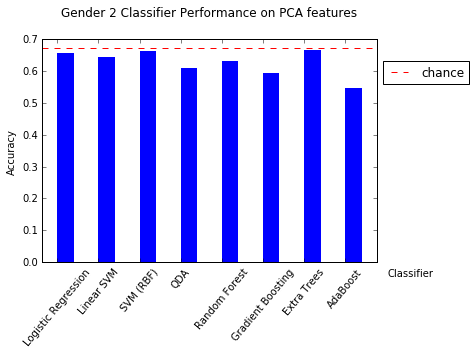

In [10]:
# Classification using PCA features
print 'Using PCA features:\n'
X2 = df2_all.values
classify(X2, y2, 'Gender 2', 'PCA', 10)

Using LLE features:

Logistic Regression accuracy is 0.6696 (+/- 0.447)
Linear SVM accuracy is 0.6696 (+/- 0.447)
SVM (RBF) accuracy is 0.6696 (+/- 0.447)
QDA accuracy is 0.8609 (+/- 0.300)
Random Forest accuracy is 0.6481 (+/- 0.432)
Gradient Boosting accuracy is 0.5893 (+/- 0.369)
Extra Trees accuracy is 0.6696 (+/- 0.447)
AdaBoost accuracy is 0.5637 (+/- 0.340)


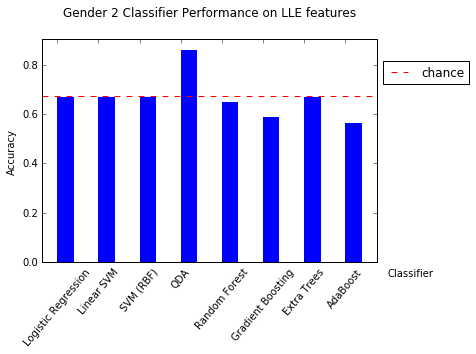

In [11]:
# Classification using LLE features
print 'Using LLE features:\n'
X2 = df2_all.values
classify(X2, y2, 'Gender 2', 'LLE', 15)

### Conclusion

Features extracted using PCA method does not give better result than chance. The highest ADHD against Bipolar prediction accuracy is yielded by LLE pipelines with QDA classification method. 

However, when using only 15 neighbors for LLE and extracting only 10 components, QDA gave the worst prediction result ever. For some reason, LLE with 25 neighbors for 15 components works great with QDA on this task